In [1]:
cd ../..

D:\Users\mrefoyo\Proyectos\Sub-SpaCE


In [2]:
import os
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

from experiments.experiment_utils import local_data_loader, label_encoder, nun_retrieval
from methods.outlier_calculators import AEOutlierCalculator
from experiments.evaluation.evaluation_utils import calculate_metrics

print(tf.__version__)

2.13.0


In [19]:
# datasets = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']
datasets = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']

# Load data and models. Calculate NUNs

In [20]:
data_dict = {}
models_dict = {}
outlier_calculators_dict = {}
nuns_idx_dict = {}
desired_classes_dict = {}
original_classes_dict = {}

for dataset in datasets:
    X_train, y_train, X_test, y_test = local_data_loader(str(dataset), data_path="./experiments/data")
    y_train, y_test = label_encoder(y_train, y_test)
    data_dict[dataset] = (X_train, y_train, X_test, y_test)

    # Load model
    model = keras.models.load_model(f'./experiments/models/{dataset}/{dataset}_best_model.hdf5')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    original_classes_dict[dataset] = y_pred
    models_dict[dataset] = model

    # Load outlier calculator
    ae = keras.models.load_model(f'./experiments/models/{dataset}/{dataset}_ae.hdf5')
    outlier_calculator = AEOutlierCalculator(ae, X_train)
    outlier_calculators_dict[dataset] = outlier_calculator  

    # Get the NUNs
    nuns_idx = []
    desired_classes = []
    for instance_idx in range(len(X_test)):
        distances, indexes, labels = nun_retrieval(X_test[instance_idx], y_pred[instance_idx], 'euclidean', 1, X_train, y_train)
        nuns_idx.append(indexes[0])
        desired_classes.append(labels[0])
    nuns_idx_dict[dataset] = np.array(nuns_idx)
    desired_classes_dict[dataset] = np.array(desired_classes)

4/4 [==============================] - 0s 9ms/step


# Compare results

In [21]:
# methods = None
# methods = ['wcf_ng', 'ng', 'tsevo_v3_reduced', 'gen_v6_complete21']
# methods = ['ng', 'ng_ours', 'ng_tsinterpret', 'sets', 'sets_tsinterpret', 'sets_our_ng', 'subspace']
# methods = ['ng', 'sets', 'sets_tsinterpret', 'sets_our_ng', 'subspace']
methods = ['wcf_ng', 'ng', 'ab_cf', 'subspace']
counterfactual_methods = [f"{method}.pickle" for method in methods]

## All samples of the test set

In [22]:
final_table_results_all = {}
sol_cfs_dict = {}

all_samples_results_all = pd.DataFrame()
for dataset in datasets:
    print(f'Calculating metrics for {dataset}')
    # Load all solutions for the dataset and calculate metrics
    results_df = pd.DataFrame()
    counterfactual_solution_files = [fname for fname in os.listdir(f'./experiments/results/{dataset}/')]
    sol_cfs_dataset = {}
    for i, sol_file_name in enumerate(counterfactual_solution_files):
        # Filter methods in case methods is not None
        if methods is not None:
            if sol_file_name not in counterfactual_methods:
                continue
        # Filter out those results with reduced in the name
        if ("reduced" in sol_file_name) or ("-" in sol_file_name):
            continue
        with open(f'./experiments/results/{dataset}/{sol_file_name}', 'rb') as f:
            print(sol_file_name)
            sol_cfs = pickle.load(f)
        X_train, y_train, X_test, y_test = data_dict[dataset]
        sol_name = sol_file_name.replace('.pickle', '')
        sol_metrics = calculate_metrics(models_dict[dataset], outlier_calculators_dict[dataset], 
                                        X_train, X_test, nuns_idx_dict[dataset],
                                        sol_cfs, original_classes_dict[dataset], sol_name, order=i+1)
        results_df = pd.concat([results_df, sol_metrics])
        sol_cfs_dataset[sol_name] = sol_cfs

    sol_cfs_dict[dataset] = sol_cfs_dataset
    # Calculate results table for the dataset
    means_df = results_df.groupby('method').mean()
    means_df = means_df.sort_values('order').drop('order', axis=1)
    stds_df = results_df.groupby('method').std()
    stds_df = stds_df.drop('order', axis=1)
    stds_df = stds_df.reindex(means_df.index)
    mean_std_df = means_df.round(2).astype(str) + " ± " + stds_df.round(2).astype(str)
    mean_std_df = mean_std_df.reset_index()
    final_table_results_all[dataset] = mean_std_df

    results_df['dataset'] = dataset
    all_samples_results_all = pd.concat([all_samples_results_all, results_df])

Calculating metrics for CBF
ab_cf.pickle


100%|██████████| 900/900 [00:44<00:00, 20.05it/s]


ng.pickle


100%|██████████| 900/900 [00:44<00:00, 20.10it/s]


subspace.pickle


100%|██████████| 900/900 [00:44<00:00, 20.22it/s]


wcf_ng.pickle


100%|██████████| 900/900 [00:45<00:00, 19.99it/s]


Calculating metrics for chinatown
ab_cf.pickle


100%|██████████| 343/343 [00:16<00:00, 20.55it/s]


ng.pickle


100%|██████████| 343/343 [00:16<00:00, 20.52it/s]


subspace.pickle


100%|██████████| 343/343 [00:16<00:00, 20.43it/s]


wcf_ng.pickle


100%|██████████| 343/343 [00:16<00:00, 20.33it/s]


Calculating metrics for coffee
ab_cf.pickle


100%|██████████| 28/28 [00:01<00:00, 19.46it/s]


ng.pickle


100%|██████████| 28/28 [00:01<00:00, 19.26it/s]


subspace.pickle


100%|██████████| 28/28 [00:01<00:00, 19.06it/s]


wcf_ng.pickle


100%|██████████| 28/28 [00:01<00:00, 19.07it/s]


Calculating metrics for gunpoint
ab_cf.pickle


100%|██████████| 150/150 [00:07<00:00, 19.81it/s]


ng.pickle


100%|██████████| 150/150 [00:07<00:00, 19.79it/s]


subspace.pickle


100%|██████████| 150/150 [00:08<00:00, 18.67it/s]


wcf_ng.pickle


100%|██████████| 150/150 [00:07<00:00, 18.97it/s]


Calculating metrics for ECG200
ab_cf.pickle


100%|██████████| 100/100 [00:05<00:00, 19.11it/s]


ng.pickle


100%|██████████| 100/100 [00:05<00:00, 18.93it/s]


subspace.pickle


100%|██████████| 100/100 [00:05<00:00, 19.05it/s]


wcf_ng.pickle


100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


In [23]:
from IPython.display import display
for dataset in datasets:
    print(dataset)
    display(final_table_results_all[dataset])

CBF


,method,nchanges,sparsity,L1,L2,proba,valid,outlier_score,increase_outlier_score,subsequences,subsequences %,times
0,ab_cf,67.03 ± 23.28,0.52 ± 0.18,48.87 ± 17.89,7.46 ± 1.97,0.83 ± 0.16,1.0 ± 0.0,0.94 ± 0.13,0.13 ± 0.11,2.46 ± 0.75,0.04 ± 0.01,-1.0 ± 0.0
1,ng,39.71 ± 16.26,0.31 ± 0.13,28.86 ± 11.59,5.6 ± 1.44,0.63 ± 0.13,0.96 ± 0.19,0.91 ± 0.12,0.1 ± 0.09,1.0 ± 0.0,0.02 ± 0.0,-1.0 ± 0.0
2,subspace,25.43 ± 11.63,0.2 ± 0.09,25.83 ± 11.26,5.83 ± 1.45,0.97 ± 0.03,1.0 ± 0.0,0.87 ± 0.08,0.05 ± 0.06,2.41 ± 0.98,0.04 ± 0.02,170.36 ± 94.35
3,wcf_ng,87.22 ± 59.18,0.68 ± 0.46,12.74 ± 14.3,6.1 ± 13.22,0.53 ± 0.04,1.0 ± 0.0,1.05 ± 0.57,0.24 ± 0.56,1.14 ± 0.44,0.02 ± 0.01,-1.0 ± 0.0


chinatown


,method,nchanges,sparsity,L1,L2,proba,valid,outlier_score,increase_outlier_score,subsequences,subsequences %,times
0,ab_cf,9.03 ± 1.63,0.38 ± 0.07,956.16 ± 287.53,430.97 ± 123.65,0.95 ± 0.1,1.0 ± 0.0,0.56 ± 0.13,0.02 ± 0.04,1.1 ± 0.31,0.09 ± 0.03,-1.0 ± 0.0
1,ng,7.92 ± 1.8,0.33 ± 0.08,841.67 ± 265.55,393.09 ± 124.49,0.91 ± 0.14,1.0 ± 0.0,0.56 ± 0.13,0.02 ± 0.04,1.0 ± 0.0,0.08 ± 0.0,-1.0 ± 0.0
2,subspace,2.87 ± 0.88,0.12 ± 0.04,648.06 ± 231.99,400.14 ± 120.53,0.97 ± 0.04,1.0 ± 0.0,0.56 ± 0.12,0.02 ± 0.03,1.21 ± 0.41,0.1 ± 0.03,34.71 ± 2.74
3,wcf_ng,23.2 ± 4.23,0.97 ± 0.18,1671.17 ± 585.41,662.7 ± 211.41,0.63 ± 0.1,1.0 ± 0.0,0.77 ± 0.17,0.19 ± 0.14,1.0 ± 0.0,0.08 ± 0.0,-1.0 ± 0.0


coffee


,method,nchanges,sparsity,L1,L2,proba,valid,outlier_score,increase_outlier_score,subsequences,subsequences %,times
0,ab_cf,159.0 ± 44.47,0.56 ± 0.16,13.43 ± 4.56,1.38 ± 0.36,0.87 ± 0.16,1.0 ± 0.0,0.87 ± 0.06,0.01 ± 0.02,1.54 ± 0.74,0.01 ± 0.01,-1.0 ± 0.0
1,ng,37.18 ± 17.53,0.13 ± 0.06,6.29 ± 2.26,1.26 ± 0.24,0.67 ± 0.17,1.0 ± 0.0,0.9 ± 0.1,0.04 ± 0.04,1.0 ± 0.0,0.01 ± 0.0,-1.0 ± 0.0
2,subspace,23.07 ± 8.25,0.08 ± 0.03,4.06 ± 1.7,1.01 ± 0.3,0.99 ± 0.01,1.0 ± 0.0,0.88 ± 0.08,0.02 ± 0.03,3.0 ± 0.94,0.02 ± 0.01,49.33 ± 4.79
3,wcf_ng,286.0 ± 0.0,1.0 ± 0.0,3.2 ± 1.5,1.1 ± 0.25,0.59 ± 0.06,1.0 ± 0.0,0.92 ± 0.09,0.06 ± 0.04,1.0 ± 0.0,0.01 ± 0.0,-1.0 ± 0.0


gunpoint


,method,nchanges,sparsity,L1,L2,proba,valid,outlier_score,increase_outlier_score,subsequences,subsequences %,times
0,ab_cf,65.2 ± 40.87,0.43 ± 0.27,17.58 ± 14.58,2.92 ± 1.86,0.89 ± 0.13,1.0 ± 0.0,0.66 ± 0.16,0.11 ± 0.11,1.98 ± 0.52,0.03 ± 0.01,-1.0 ± 0.0
1,ng,29.17 ± 22.3,0.19 ± 0.15,10.59 ± 9.39,2.34 ± 1.74,0.63 ± 0.12,1.0 ± 0.0,0.7 ± 0.24,0.14 ± 0.16,1.0 ± 0.0,0.01 ± 0.0,-1.0 ± 0.0
2,subspace,13.14 ± 8.11,0.09 ± 0.05,4.95 ± 4.46,1.5 ± 0.99,0.96 ± 0.03,1.0 ± 0.0,0.61 ± 0.12,0.05 ± 0.05,2.16 ± 0.83,0.03 ± 0.01,58.91 ± 8.24
3,wcf_ng,141.16 ± 35.11,0.94 ± 0.23,3.62 ± 2.59,1.0 ± 1.04,0.55 ± 0.04,1.0 ± 0.0,0.65 ± 0.17,0.09 ± 0.09,1.08 ± 0.38,0.01 ± 0.01,-1.0 ± 0.0


ECG200


,method,nchanges,sparsity,L1,L2,proba,valid,outlier_score,increase_outlier_score,subsequences,subsequences %,times
0,ab_cf,56.78 ± 29.39,0.59 ± 0.31,23.0 ± 14.87,3.77 ± 1.85,0.9 ± 0.14,0.94 ± 0.24,0.81 ± 0.19,0.09 ± 0.11,1.61 ± 0.78,0.03 ± 0.02,-1.0 ± 0.0
1,ng,16.67 ± 21.39,0.17 ± 0.22,8.89 ± 9.11,2.62 ± 1.48,0.78 ± 0.18,1.0 ± 0.0,0.8 ± 0.2,0.07 ± 0.11,1.0 ± 0.0,0.02 ± 0.0,-1.0 ± 0.0
2,subspace,6.81 ± 4.89,0.07 ± 0.05,5.88 ± 5.45,2.46 ± 1.37,0.98 ± 0.02,1.0 ± 0.0,0.79 ± 0.15,0.04 ± 0.06,1.33 ± 0.74,0.03 ± 0.02,48.89 ± 1.42
3,wcf_ng,58.22 ± 46.51,0.61 ± 0.48,3.78 ± 2.56,2.22 ± 1.71,0.59 ± 0.07,1.0 ± 0.0,0.86 ± 0.26,0.12 ± 0.14,1.21 ± 0.48,0.03 ± 0.01,-1.0 ± 0.0


In [24]:
methods_trad_dict = dict(zip(methods, ['W-CF', 'NG', 'AB-CF', 'Sub-SpaCE']))
methods_order = dict(zip(list(methods_trad_dict.values()), list(range(len(methods_trad_dict)))))

datasets_trad_dict = {"CBF": "CBF", "chinatown": "Chinatown", "coffee": "Coffee", "gunpoint": "Gunpoint"}
datasets_order = dict(zip(list(datasets_trad_dict.values()), list(range(len(datasets_trad_dict)))))

metrics_trad_dict = {'nchanges': '# changes', 'sparsity': 'Sparsity', 'L1': 'Proximity ($L_1$)', 'L2': 'Proximity ($L_2$)', 'valid': 'Validity',
                     'increase_outlier_score': 'IOS', 'subsequences': 'NoS', 'subsequences %': 'NoS [%]'}

groupby_trad_dict = {'method': 'Method' , 'dataset': 'Dataset'}

methods_trad = list(methods_trad_dict.values())
metrics = list(metrics_trad_dict.values())
groupby_cols = list(groupby_trad_dict.values())

In [25]:
final_df = all_samples_results_all.rename(columns={**metrics_trad_dict, **groupby_trad_dict})
final_df = final_df.replace(methods_trad_dict)
final_df = final_df.replace(datasets_trad_dict)
final_df['Validity'] = final_df['Validity'].astype(int)


all_table_df = final_df.groupby(groupby_cols).mean()
all_table_df.reset_index().pivot(index='Method', columns='Dataset', values=metrics)

# changes                                                Sparsity  \
Dataset          CBF  Chinatown      Coffee     ECG200    Gunpoint       CBF   
Method                                                                         
AB-CF      67.026667   9.029155  159.000000  56.776596   65.200000  0.523646   
NG         39.712139   7.918367   37.178571  16.670000   29.166667  0.310251   
Sub-SpaCE  25.425556   2.865889   23.071429   6.810000   13.140000  0.198637   
W-CF       87.217778  23.195335  286.000000  58.220000  141.160000  0.681389   

                                                   ...       NoS            \
Dataset   Chinatown    Coffee    ECG200  Gunpoint  ...       CBF Chinatown   
Method                                             ...                       
AB-CF      0.376215  0.555944  0.591423  0.434667  ...  2.461111  1.104956   
NG         0.329932  0.129995  0.173646  0.194444  ...  1.000000  1.000000   
Sub-SpaCE  0.119412  0.080669  0.070938  0.087600  ...  2.407778  1.209913   
W-CF       0.966472  1.000000  0.606458  0.941067  ...  1.137778  1.000000   

                                         NoS [%]                      \
Dataset      Coffee    ECG200 Gunpoint       CBF Chinatown    Coffee   
Method                                                                 
AB-CF      1.535714  1.606383     1.98  0.038455  0.092080  0.010739   
NG         1.000000  1.000000     1.00  0.015625  0.083333  0.006993   
Sub-SpaCE  3.000000  1.330000     2.16  0.037622  0.100826  0.020979   
W-CF       1.000000  1.210000     1.08  0.017778  0.083333  0.006993   

                               
Dataset      ECG200  Gunpoint  
Method                         
AB-CF      0.033466  0.026400  
NG         0.020833  0.013333  
Sub-SpaCE  0.027708  0.028800  
W-CF       0.025208  0.014400  

[4 rows x 40 columns]

In [26]:
final_metrics = {
    'Validity': 'max', 
    'Sparsity': 'min',
    'Proximity ($L_1$)': 'min',
    'Proximity ($L_2$)': 'min', 
    'IOS': 'min',
    'NoS': 'min'
}

for metric, operation in final_metrics.items(): 
    metric_mean_df = final_df.groupby(groupby_cols).mean()
    metric_mean_df = metric_mean_df.reset_index().pivot(index='Method', columns='Dataset', values=[metric])
    metric_mean_df = metric_mean_df.reindex(methods_trad).rename(index=methods_trad_dict)
    metric_mean_df = metric_mean_df.round(2)
    # Convert to string with 2 decimals
    for column in metric_mean_df.columns:
        metric_mean_df[column] = metric_mean_df[column].apply(lambda x: f'{x:.2f}')

    metric_stds_df = final_df.groupby(groupby_cols).std()
    metric_stds_df = metric_stds_df.reset_index().pivot(index='Method', columns='Dataset', values=[metric])
    metric_stds_df = metric_stds_df.reindex(methods_trad).rename(index=methods_trad_dict)
    metric_stds_df = metric_stds_df.round(2)
    # Convert to string
    for column in metric_stds_df.columns:
        metric_stds_df[column] = metric_stds_df[column].apply(lambda x: f'{x:.2f}')
    
    mean_std_df = metric_mean_df.astype(str) + " ± " + metric_stds_df.astype(str)

    latex_table = mean_std_df.to_latex(index=True)
    latex_table = latex_table.replace("{r}", "{c}")
    latex_table = latex_table.replace("begin{tabular}{" + ''.join(['l']*(len(datasets)+1)) + "}",  "begin{tabular*}{\\textwidth}{@{\\extracolsep{\\fill}}lccccc}")
    latex_table = latex_table.replace("end{tabular}",  "end{tabular*}")
    print(latex_table) 
    print()

\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}lccccc}
\toprule
 & \multicolumn{5}{c}{Validity} \\
Dataset & CBF & Chinatown & Coffee & ECG200 & Gunpoint \\
Method &  &  &  &  &  \\
\midrule
W-CF & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 \\
NG & 0.96 ± 0.19 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 \\
AB-CF & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 0.94 ± 0.24 & 1.00 ± 0.00 \\
Sub-SpaCE & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 & 1.00 ± 0.00 \\
\bottomrule
\end{tabular*}


\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}lccccc}
\toprule
 & \multicolumn{5}{c}{Sparsity} \\
Dataset & CBF & Chinatown & Coffee & ECG200 & Gunpoint \\
Method &  &  &  &  &  \\
\midrule
W-CF & 0.68 ± 0.46 & 0.97 ± 0.18 & 1.00 ± 0.00 & 0.61 ± 0.48 & 0.94 ± 0.23 \\
NG & 0.31 ± 0.13 & 0.33 ± 0.08 & 0.13 ± 0.06 & 0.17 ± 0.22 & 0.19 ± 0.15 \\
AB-CF & 0.52 ± 0.18 & 0.38 ± 0.07 & 0.56 ± 0.16 & 0.59 ± 0.31 & 0.43 ± 0.27 \\
Sub-SpaCE & 0.20 ± 0.09 & 0.12 ±

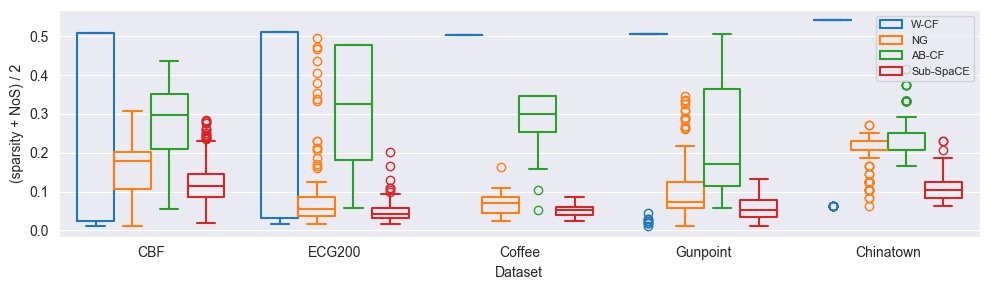

In [27]:
import seaborn as sns
methods = ['W-CF', 'NG', 'AB-CF', 'Sub-SpaCE']
methods_order = dict(zip(methods, list(range(len(methods)))))

aux_df = final_df.copy()
aux_df = aux_df[aux_df['Method'].isin(methods)]
aux_df['(sparsity + NoS) / 2'] = (aux_df['Sparsity'] + aux_df['NoS [%]']) / 2
# aux_df['(sparsity + contiguity) / 2'] = (aux_df['NoS'] / aux_df['# changes'] ) 
aux_df['Method_ord'] = aux_df['Method'].map( dict(zip(methods, list(range(len(methods))))) )
aux_df = aux_df.reset_index()
aux_df = aux_df.sort_values('Method_ord', ascending=True)


plt.figure(figsize=(10, 3))
ax = sns.boxplot(data=aux_df, x="Dataset", y="(sparsity + NoS) / 2", hue="Method", fill=False)
ax.legend(loc='upper right')
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('./experiments/results/sparsity-contiguity.PNG', dpi=300)


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_18360\652556946.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['ratio'] = (aux_df['Sparsity'] + (aux_df['NoS']/48)) / 2


<Axes: xlabel='index_ordered', ylabel='ratio'>

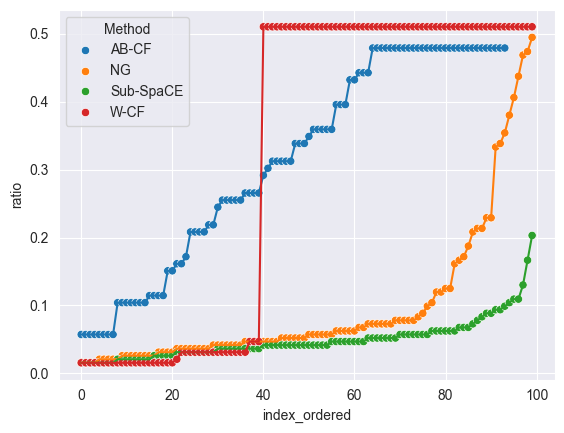

In [28]:
dataset = 'ECG200'
aux_df = final_df.copy()
aux_df = final_df[final_df['Dataset'] == dataset]

aux_df['ratio'] = (aux_df['Sparsity'] + (aux_df['NoS']/48)) / 2
# sns.scatterplot(data=aux_df, x="Contiguity", y="Sparsity", hue='Method')
aux_df = aux_df.reset_index()
aux_df = aux_df.sort_values(['Method', 'ratio'])

aux_df['index_ordered'] = aux_df.groupby(['Method']).cumcount().values
sns.scatterplot(data=aux_df, x="index_ordered", y="ratio", hue='Method')
sns.lineplot(data=aux_df, x="index_ordered", y="ratio", hue='Method', legend=False)

<Axes: xlabel='index_ordered', ylabel='ratio'>

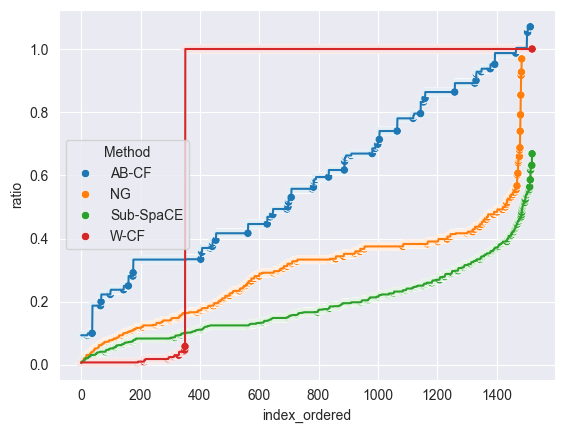

In [29]:
aux_df = final_df.copy()

aux_df['ratio'] = aux_df['Sparsity'] * (aux_df['NoS']**0.25)
# sns.scatterplot(data=aux_df, x="Contiguity", y="Sparsity", hue='Method')
aux_df = aux_df.reset_index()
aux_df = aux_df.sort_values(['Method', 'ratio'])

aux_df['index_ordered'] = aux_df.groupby(['Method']).cumcount().values
sns.scatterplot(data=aux_df, x="index_ordered", y="ratio", hue='Method')
sns.lineplot(data=aux_df, x="index_ordered", y="ratio", hue='Method', legend=False)

<Axes: xlabel='index_ordered', ylabel='ratio'>

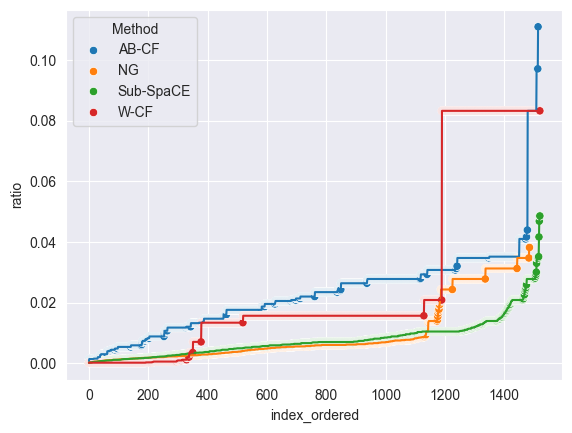

In [30]:
aux_df = final_df.copy()

aux_df['ratio'] = aux_df['Sparsity'] * aux_df['NoS [%]']
# sns.scatterplot(data=aux_df, x="Contiguity", y="Sparsity", hue='Method')
aux_df = aux_df.reset_index()
aux_df = aux_df.sort_values(['Method', 'ratio'])

aux_df['index_ordered'] = aux_df.groupby(['Method']).cumcount().values
sns.scatterplot(data=aux_df, x="index_ordered", y="ratio", hue='Method')
sns.lineplot(data=aux_df, x="index_ordered", y="ratio", hue='Method', legend=False)

# Counterfactual visualization

In [31]:
def plot_single_cf(x_orig, x_cf, title=''):
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]
    # Get change mask 
    found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
    diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    
    fig = plt.figure(figsize=(8, 3), dpi=300)
    grid = gridspec.GridSpec(n_channels, 1, wspace=0.2, hspace=0.2)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, grid[i])
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
            fig.add_subplot(ax)

        # Add ax to list of subplots
        sub_channel_axs.append(ax)

    # Add title and legend
    """fig.suptitle(title)
    fig.legend(sub_channel_axs,     # The line objects
           labels=['NUN', 'x_cf', 'x_orig'],   # The labels for each line
           title="Legend Title"  # Title for the legend
           )"""

    # Generate ax_fig and return it
    # ax_fig = fig.add_subplot(111)
    plt.show()
    # return ax_fig

In [32]:
import math
def plot_comp_cfs(x_orig, nun_example, x_cfs_dict):
    
    # Calculate auxiliary variables
    method_names = list(x_cfs_dict.keys())
    x_cfs = list(x_cfs_dict.values())
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # Define outer grid
    fig = plt.figure(figsize=(18, 6))
    grid_columns = 2
    grid_rows = math.ceil(len(x_cfs) / grid_columns)
    outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0.1, hspace=0.3)

    # Iterate through outer grid plots
    for m, outer in enumerate(outer_grid):
        try:
            # Get change mask 
            x_cf = x_cfs[m]
            method_name = method_names[m]
            found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
            diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
        except IndexError:
            break
    
        # Create inner grid
        inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0.2, hspace=0.2, subplot_spec=outer)
        sub_channel_axs = []
        for i in range(n_channels):
            ax = plt.Subplot(fig, inner_grid[i])
            ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
            ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
            ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
            # Set title if first channel
            if i == 0:
                ax.set_title(method_name)
            
            # Add fill to changes
            starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
            ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
            # Iterate over the mask segments and fill them with red color
            for i in range(0, len(starts)):
                start_idx = starts[i]
                end_idx = ends[i]
                # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
                ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
            
            # Add ax to list of subplots
            fig.add_subplot(ax)
            sub_channel_axs.append(ax)

    # Plot figure
    fig.legend(
        sub_channel_axs,     # The line objects
        labels=['NUN', 'x_cf', 'x_orig'],   # The labels for each line
        loc='center',
        prop={'size': 12}
    )
    plt.show()



In [33]:
final_df[(final_df['Dataset'] == dataset) & (final_df['Method'] == 'Sub-SpaCE')]

,# changes,Sparsity,Proximity ($L_1$),Proximity ($L_2$),proba,Validity,outlier_score,IOS,NoS,NoS [%],times,Method,order,Dataset
0,8.0,0.083333,5.604800,2.182892,0.987211,1,0.712288,0.000000,2.0,0.041667,50.503500,Sub-SpaCE,3,ECG200
1,13.0,0.135417,10.182470,3.315098,0.989663,1,0.818314,0.000000,2.0,0.041667,49.194771,Sub-SpaCE,3,ECG200
2,10.0,0.104167,2.306904,0.890991,0.998868,1,0.704657,0.000812,1.0,0.020833,46.052440,Sub-SpaCE,3,ECG200
3,9.0,0.093750,7.508831,2.864129,0.964882,1,0.676338,0.000000,1.0,0.020833,49.177684,Sub-SpaCE,3,ECG200
4,4.0,0.041667,2.295502,1.344983,0.976563,1,0.828838,0.072047,1.0,0.020833,48.911875,Sub-SpaCE,3,ECG200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.0,0.052083,3.239736,1.711250,0.932435,1,0.720776,0.093666,1.0,0.020833,49.770471,Sub-SpaCE,3,ECG200
96,5.0,0.052083,2.744788,1.392525,0.979099,1,0.665959,0.047035,1.0,0.020833,48.149454,Sub-SpaCE,3,ECG200
97,7.0,0.072917,8.052370,3.748480,0.999446,1,0.740724,0.036002,1.0,0.020833,47.548777,Sub-SpaCE,3,ECG200
98,6.0,0.062500,10.231884,4.889394,0.999744,1,0.957987,0.117715,1.0,0.020833,51.623526,Sub-SpaCE,3,ECG200


Sample 13: original_class 0, predicted_class 0, desired_class  1


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_18360\12427846.py:54: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(


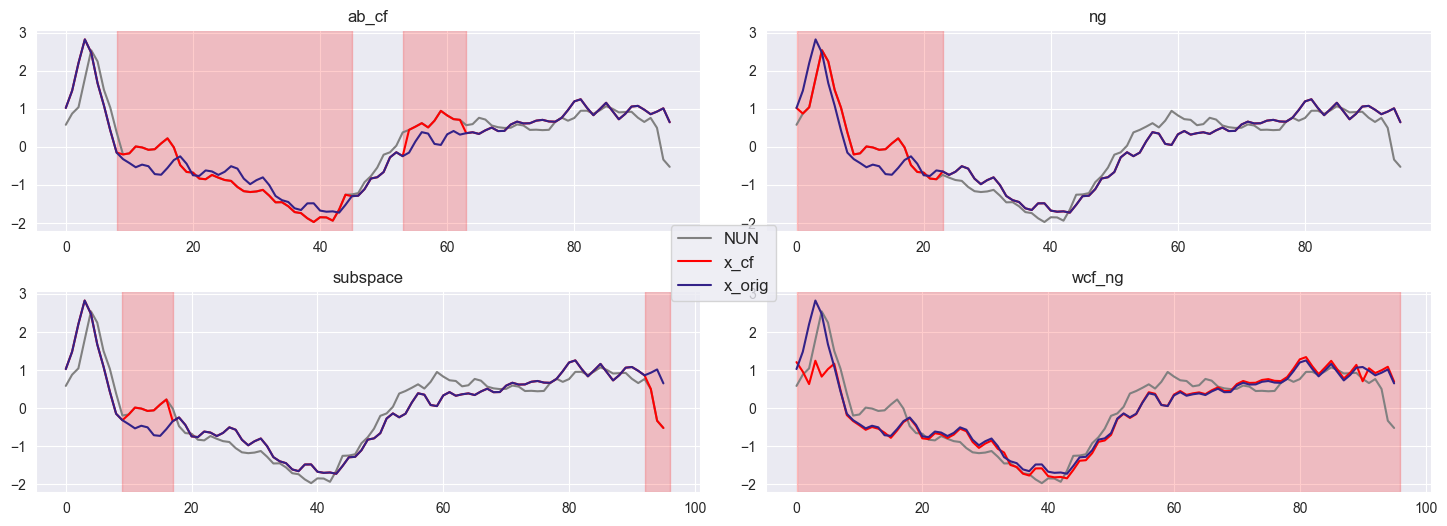

In [34]:
dataset = "ECG200"
methods = ["wcf_ng", "ng", "ab_cf", "subspace"]
instance = 13

X_train, y_train, X_test, y_test = data_dict[dataset]
nuns_idx = nuns_idx_dict[dataset]
original_classes = original_classes_dict[dataset]
desired_classes = desired_classes_dict[dataset]
sol_cfs_methods = sol_cfs_dict[dataset]
sol_cfs_methods = {method: sol_cfs[instance]['cf'] for method, sol_cfs in sol_cfs_methods.items() if method in methods}

print(f'Sample {instance}: original_class {y_test[instance]}, predicted_class {original_classes[instance]}, desired_class  {desired_classes[instance]}')
plot_comp_cfs(X_test[instance], X_train[nuns_idx[instance]], sol_cfs_methods)


In [35]:
# Create plot with examples of each method in each dataset

In [36]:
# CBF: 1, 2, 10, 18, 19
# chinatown: 3, 7, 19
# coffee: 1, 3, 9, 16
# ECG200: 0, 13
# gunpoint: 9, 10, 15 (pesimos en general)
dataset_samples = [('CBF', 2), ('chinatown', 19), ('coffee', 3), ('ECG200', 13), ('gunpoint', 15)]
methods_trad_dict = {"wcf_ng": "W-CF", "ng": "NG", "ab_cf": "AB-CF", "subspace": "Sub-SpaCE"}
methods = list(methods_trad_dict.keys())
include_nun_list = [False, False, False, False]

'fig.legend(\n    sub_channel_axs,     # The line objects\n    labels=[\'$x^n$\', \'x\', "x\'"],   # The labels for each line\n    loc=\'lower center\',\n    # loc=\'center right\',\n    prop={\'size\': 14},\n    ncol=3\n)'

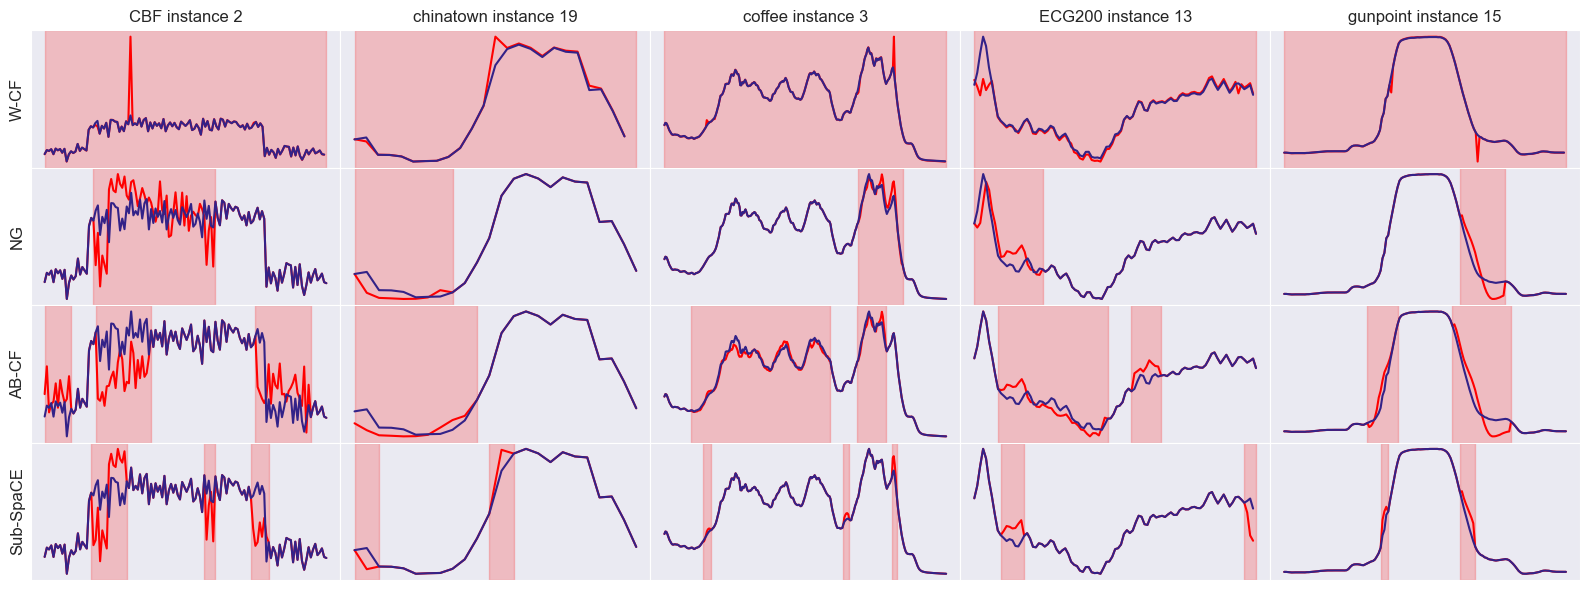

In [37]:
from collections import OrderedDict

# Define outer grid
fig = plt.figure(figsize=(16, 6))
grid_rows = len(methods)
grid_columns = len(dataset_samples)
outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0, hspace=0)

# Iterate through outer grid plots
for i_outer, outer in enumerate(outer_grid):
    i_dataset = i_outer % grid_columns
    dataset, instance = dataset_samples[i_dataset]
    column_title = f'{dataset} instance {instance}'
    
    X_train, y_train, X_test, y_test = data_dict[dataset]
    nuns_idx = nuns_idx_dict[dataset]
    sol_cfs_methods = sol_cfs_dict[dataset]
    sol_cfs_methods = {method: sol_cfs_methods[method][instance]['cf'] for method in methods}

    # Calculate auxiliary variables
    method_names = list(sol_cfs_methods.keys())
    x_cfs = list(sol_cfs_methods.values())
    x_orig = X_test[instance]
    nun_example = X_train[nuns_idx[instance]]
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # get method m
    m = i_outer // grid_columns
    try:
        # Get change mask 
        x_cf = x_cfs[m]
        method_name = method_names[m]
        found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
        diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    except IndexError:
        break

    # Create inner grid
    inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0, hspace=0, subplot_spec=outer)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, inner_grid[i])
        if include_nun_list[m]:
            ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
        
        # Set column titles
        if m == 0:
            ax.set_title(column_title)
        if i_dataset == 0:
            ax.set_ylabel(methods_trad_dict[method_name], size='large')
        # Add ax to list of subplots
        fig.add_subplot(ax)
        sub_channel_axs.append(ax)

# Plot figure
plt.tight_layout()
"""fig.legend(
    sub_channel_axs,     # The line objects
    labels=['$x^n$', 'x', "x'"],   # The labels for each line
    loc='lower center',
    # loc='center right',
    prop={'size': 14},
    ncol=3
)"""
# plt.show()
# plt.savefig('./experiments/results/examples_cfs.png', dpi=300)


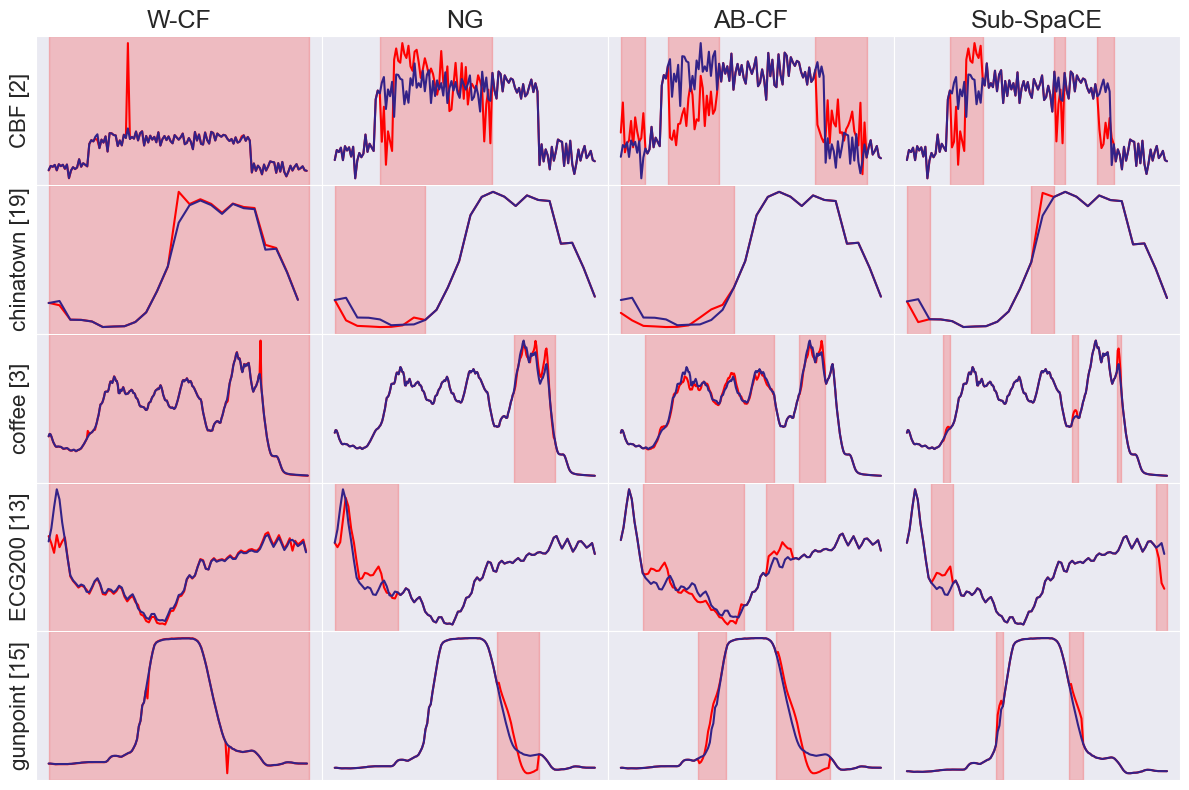

In [41]:
from collections import OrderedDict

# Define outer grid
fig = plt.figure(figsize=(12, 8))
grid_rows = len(dataset_samples)
grid_columns = len(methods)
outer_grid = gridspec.GridSpec(grid_rows, grid_columns, wspace=0, hspace=0)

# Iterate through outer grid plots
for i_outer, outer in enumerate(outer_grid):
    i_dataset = i_outer // grid_columns
    dataset, instance = dataset_samples[i_dataset]
    
    X_train, y_train, X_test, y_test = data_dict[dataset]
    nuns_idx = nuns_idx_dict[dataset]
    sol_cfs_methods = sol_cfs_dict[dataset]
    sol_cfs_methods = {method: sol_cfs_methods[method][instance]['cf'] for method in methods}

    # Calculate auxiliary variables
    method_names = list(sol_cfs_methods.keys())
    x_cfs = list(sol_cfs_methods.values())
    x_orig = X_test[instance]
    nun_example = X_train[nuns_idx[instance]]
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]

    # get method m
    m = i_outer % grid_columns
    try:
        # Get change mask 
        x_cf = x_cfs[m]
        method_name = method_names[m]
        found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
        diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    except IndexError:
        break
    
    # Create inner grid
    inner_grid = gridspec.GridSpecFromSubplotSpec(n_channels, 1, wspace=0, hspace=0, subplot_spec=outer)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, inner_grid[i])
        if include_nun_list[m]:
            ax.plot(nun_example.reshape(1, length, n_channels)[:, :, i].flatten(), color='grey')
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
        
        # Set column titles
        column_title = methods_trad_dict[method_name]
        # row_title = f'{dataset} \n instance {instance}'
        row_title = f'{dataset} [{instance}]'
        if m == 0:
            ax.set_ylabel(row_title, fontsize=16, rotation=90)
        if i_dataset == 0:
            ax.set_title(column_title, fontsize=18)
            
        # Add ax to list of subplots
        fig.add_subplot(ax)
        sub_channel_axs.append(ax)

# Plot figure
plt.tight_layout()
"""fig.legend(
    sub_channel_axs,     # The line objects
    labels=['$x^n$', 'x', "x'"],   # The labels for each line
    # loc='lower center',
    loc='center right',
    prop={'size': 18},
    ncol=1
)"""
# plt.show()
plt.savefig('./experiments/results/examples_cfs.png', dpi=600)
